In [2]:
import os
import cv2
import random
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
train_dir = 'data/Training'
test_dir = 'data/Testing'
classes = os.listdir(train_dir)
resize_size = 256
crop_size = 224

def preprocess_image(image):
    image = tf.image.resize(image, [resize_size, resize_size], method=tf.image.ResizeMethod.BILINEAR) #크기 조절
    image = tf.image.central_crop(image, central_fraction=crop_size / resize_size) #중앙 224x224
    image = tf.math.divide(image, 255.0) #normalize
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std #다 normalize

    return image


def resize_and_crop(image, resize_size=256, crop_size=224):
    # Resize with bilinear interpolation
    resized_image = tf.image.resize(image, [resize_size, resize_size], method=tf.image.ResizeMethod.BILINEAR)
    cropped_image = tf.image.central_crop(resized_image, central_fraction=crop_size / resize_size)
    image = tf.math.divide(cropped_image, 255.0) #normalize

    return image


from sklearn.preprocessing import LabelEncoder

X = [] #Image
y = [] #class
Original_X = []
for i in classes:
    for data_dir in [train_dir, test_dir]:
        folderPath = os.path.join(data_dir,i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j)) #이미지 읽기
            O_img = resize_and_crop(img)
            Original_X.append(O_img)
            img = preprocess_image(img) #전처리
            X.append(img) #X list 넣고
            y.append(i) # y list
X = np.array(X)
y = np.array(y)
y = tf.keras.utils.to_categorical([classes.index(label) for label in y]) #문자열 -> [0,3]
Original_X = np.array(Original_X)

  4%|█▊                                        | 17/395 [00:00<00:04, 92.08it/s]

Metal device set to: Apple M2 Pro


100%|██████████████████████████████████████████| 74/74 [00:00<00:00, 125.50it/s]


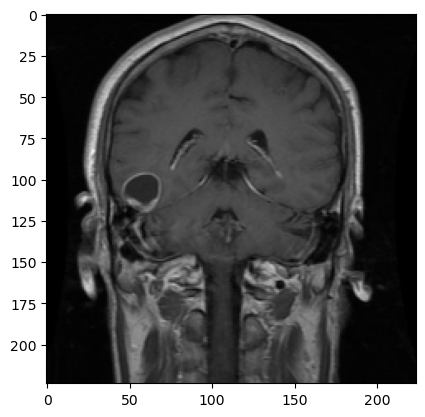

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


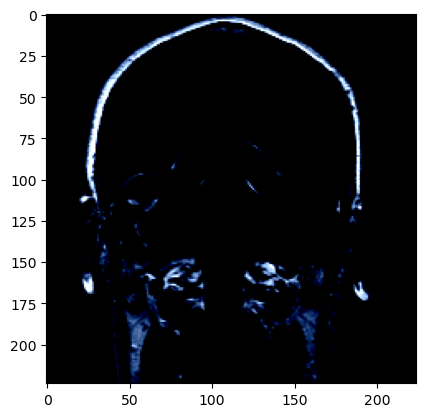

In [3]:
index_to_use = 2300

plt.imshow(Original_X[120])
plt.imshow(Original_X[index_to_use])
plt.show()

plt.imshow(X[index_to_use])
plt.show()

In [4]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import layers, models
from vit_keras import vit, utils
from lime.lime_image import LimeImageExplainer
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
import shap

model_name = "original_model/eff/"
model = keras.models.load_model(model_name+"best_model.h5")

/Users/sunyoung-park/miniforge3/envs/tf_gpu/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42) #training 분할 (train,val)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=42) #training 분할 (train,val)

In [6]:
y_pred = model.predict(X_test)
y_pred_single_label = np.argmax(y_pred, axis=1)
y_test_single_label = np.argmax(y_test, axis=1)
precision = precision_score(y_test_single_label, y_pred_single_label, average='macro')
recall = recall_score(y_test_single_label, y_pred_single_label, average='macro')
f1 = f1_score(y_test_single_label, y_pred_single_label, average='macro')
accuracy = accuracy_score(y_test_single_label, y_pred_single_label)
precision = round(precision, 3)
recall = round(recall, 3)
f1 = round(f1, 3)
accuracy = round(accuracy, 3)
print(str(model_name))
print(precision, recall, f1, accuracy)

2023-11-19 17:04:51.527472: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11/11 [==============================] - 16s 878ms/step
original_model/eff/
0.669 0.597 0.578 0.587


In [7]:
import cv2
import numpy as np
from tensorflow import keras

selected_image = X[index_to_use]
selected_image = np.expand_dims(selected_image, axis=0)
prediction = model.predict(selected_image)
predicted_class = np.argmax(prediction)

print("Predicted Class:", predicted_class)
print("real class:", np.argmax(y[index_to_use]))

1/1 [==============================] - 5s 5s/step
Predicted Class: 0
real class: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 114ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


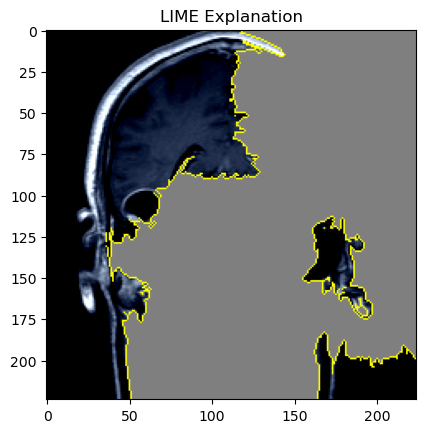

In [8]:
import os
import cv2
import random
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, models
from vit_keras import vit, utils
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import shap
import numpy as np
import pandas as pd

explainer = LimeImageExplainer(feature_selection='auto')
explanation = explainer.explain_instance(selected_image[0], model.predict, top_labels=1, hide_color=0, num_samples=1000)

# Plot LIME explanation for positive and negative features on the original image
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
mask = cv2.resize(mask, (selected_image.shape[2], selected_image.shape[1]))

plt.imshow(mark_boundaries(Original_X[index_to_use], mask))
plt.title('LIME Explanation')

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


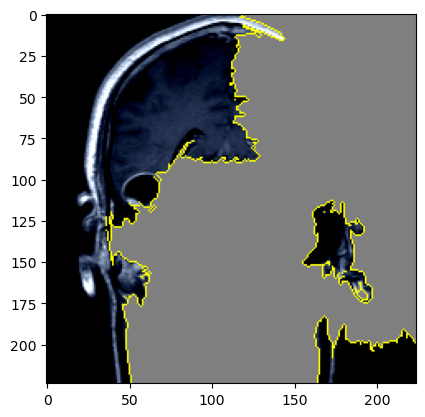

In [9]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


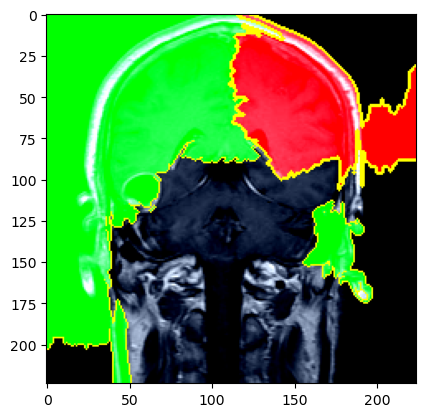

In [10]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

def get_gradcam(img_array, model, layer_name):
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
    
    # Resize CAM to image size
    cam = cv2.resize(cam.numpy(), (img_array.shape[2], img_array.shape[1]))
    cam = np.maximum(cam, 0)

    # Normalize CAM
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    return cam

def overlay_gradcam(original_image, cam):
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Convert original_image to uint8
    original_image_uint8 = np.uint8(original_image * 255)

    # Add the images
    superimposed_img = cv2.addWeighted(original_image_uint8, 0.6, heatmap, 0.4, 0)

    return superimposed_img

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.99s/it]                            


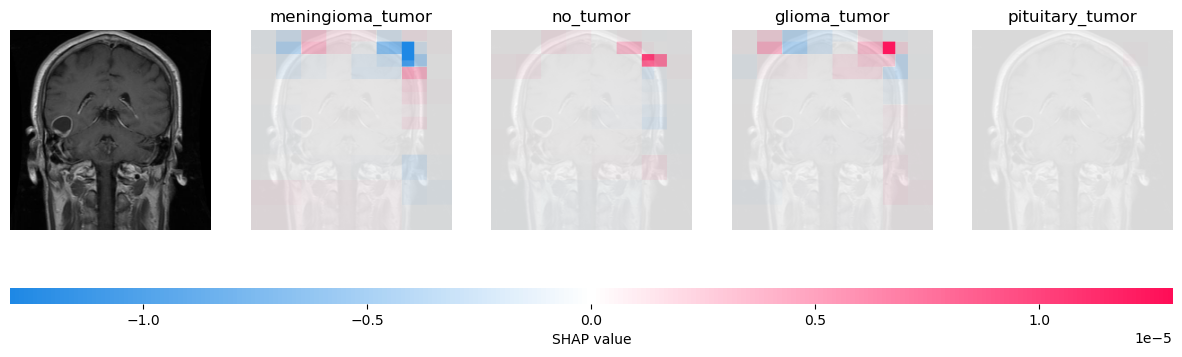

In [12]:
import shap

#shap도 비슷 (빨간색 : 긍정적, 파란색: 부정적)
shap.initjs()
masker = shap.maskers.Image(explanation.top_labels[0], X[index_to_use].shape)
explainer = shap.Explainer(model, masker, output_names=classes)
explainer
shap_values = explainer(Original_X[index_to_use:index_to_use+1], outputs=shap.Explanation.argsort.flip[:5])
shap_values.shape
shap.image_plot(shap_values)

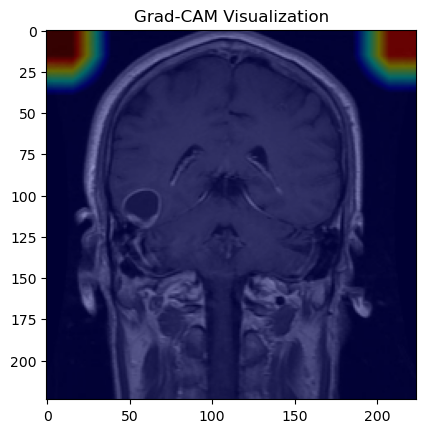

In [13]:
# Assuming 'model' is your trained model and 'layer_name' is the name of the last convolutional layer
layer_name = 'top_conv'

# Get Grad-CAM
cam = get_gradcam(selected_image[0], model, layer_name)

# Overlay Grad-CAM on the original image
gradcam_overlay = overlay_gradcam(Original_X[index_to_use], cam)

# Plot Grad-CAM
plt.imshow(gradcam_overlay)
plt.title('Grad-CAM Visualization')
plt.show()